# BRD4 Interpolation in Latent Space

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import rdkit.Chem.PandasTools as PandasTools

PandasTools.InstallPandasTools()

In [4]:
import os

### Analysis Variables

In [5]:
blob="lig_gen"

### Helper Functions

TODO: Extract such functions in a Python module.

In [6]:
def root_and_prefix(datafile):
    """
    Root directory and prefix.
    """
    dataroot = os.path.dirname(datafile)
    prefix, _ = os.path.splitext(os.path.basename(datafile))
    
    return dataroot, prefix

## Variability Factor 1.0

### Data

In [7]:
droot = "data/BRD4/sdf/"

In [8]:
datafile = "generated/BRD4recinterpolation_vf1.0_inter.gen_metrics"

Load generative model metrics (from `*.gen_metrics` file):

In [9]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'BRD4recinterpolation_vf1.0_inter'

In [10]:
system = prefix.split("_")[0]
system

'BRD4recinterpolation'

In [11]:
with open(f"data/{system}.types", "r") as f:
    inputs = f.readlines()
    
inputs

['1 0.00 BRD4/pdb/BRD4.pdb BRD4/sdf/ligand-1.sdf\n',
 '1 0.00 BRD4/pdb/BRD4.pdb BRD4/sdf/ligand-10.sdf\n',
 '1 0.00 BRD4/pdb/BRD4.pdb BRD4/sdf/ligand-2.sdf\n',
 '1 0.00 BRD4/pdb/BRD4.pdb BRD4/sdf/ligand-3.sdf\n']

In [12]:
def ligname(line):
    ligfile = line.strip().split()[-1]
    ligname = os.path.splitext(os.path.basename(ligfile))[0]
    return ligname

ligand_pairs = [(ligname(inputs[i]), ligname(inputs[i+1])) for i in range(0, len(inputs), 2)]
ligand_pairs

[('ligand-1', 'ligand-10'), ('ligand-2', 'ligand-3')]

In [13]:
interpolations = {}

In [14]:
for ligandpair in ligand_pairs:
    molecules = []
    
    lig1, lig2 = ligandpair
    
    # Start molecule
    molecules.append(next(Chem.SDMolSupplier(f"{droot}/{lig1}.sdf")))
    AllChem.Compute2DCoords(molecules[0])
    
    lig1f = f"generated/{prefix}_{lig1}_{blob}_fit_add.sdf"
    suppl1 = Chem.SDMolSupplier(lig1f)
    for mol in suppl1:
        if mol is not None:
            AllChem.Compute2DCoords(mol)
            molecules.append(mol)
            
    lig2f = f"generated/{prefix}_{lig2}_{blob}_fit_add.sdf"
    suppl2 = Chem.SDMolSupplier(lig2f)
    for mol in suppl2:
        if mol is not None:
            AllChem.Compute2DCoords(mol)
            molecules.append(mol)
            
    # End molecule
    molecules.append(next(Chem.SDMolSupplier(f"{droot}/{lig2}.sdf")))
    AllChem.Compute2DCoords(molecules[-1])
            
    interpolations[f"{lig1}/{lig2}"] = molecules

RDKit ERROR: [15:22:28] Explicit valence for atom # 16 Cl, 3, is greater than permitted
RDKit ERROR: [15:22:28] ERROR: Could not sanitize molecule ending on line 867
RDKit ERROR: [15:22:28] ERROR: Explicit valence for atom # 16 Cl, 3, is greater than permitted
RDKit ERROR: [15:22:28] Explicit valence for atom # 17 Cl, 2, is greater than permitted
RDKit ERROR: [15:22:28] ERROR: Could not sanitize molecule ending on line 919
RDKit ERROR: [15:22:28] ERROR: Explicit valence for atom # 17 Cl, 2, is greater than permitted
RDKit ERROR: [15:22:28] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [15:22:28] ERROR: Could not sanitize molecule ending on line 536


In [15]:
def tsimilarity(molecules):
    
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) for mol in molecules]
    
    start_fp = fps[0]
    end_fp = fps[-1]
    
    sim_with_start = []
    sim_with_end = []
    for fp in fps:
        sim_with_start.append(DataStructs.FingerprintSimilarity(fp,start_fp))
        sim_with_end.append(DataStructs.FingerprintSimilarity(fp,end_fp))
        
    return sim_with_start[1:-1], sim_with_end[1:-1]

In [16]:
def msimilarity(molecules):
    from rdkit.Chem import MACCSkeys
    
    fps = [MACCSkeys.GenMACCSKeys(mol) for mol in molecules]
    
    start_fp = fps[0]
    end_fp = fps[-1]
    
    sim_with_start = []
    sim_with_end = []
    for fp in fps:
        sim_with_start.append(DataStructs.FingerprintSimilarity(fp,start_fp))
        sim_with_end.append(DataStructs.FingerprintSimilarity(fp,end_fp))
        
    return sim_with_start[1:-1], sim_with_end[1:-1]

## First Interpolation

In [17]:
idx = 0 # Interpolation index (first pair, second pair, ...)
key = list(interpolations.keys())[idx]

In [18]:
key

'ligand-1/ligand-10'

In [19]:
tsim_start, tsim_end = tsimilarity(interpolations[key])

Text(0, 0.5, 'Tanimoto Similatiry')

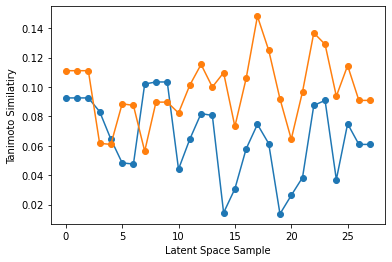

In [20]:
plt.plot(range(len(tsim_start)), tsim_start,"o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), tsim_end,"o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")

In [21]:
msim_start, msim_end = msimilarity(interpolations[key])

Text(0.5, 1.0, 'MACCS')

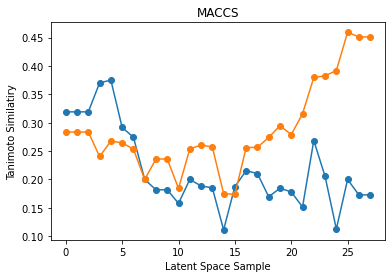

In [22]:
plt.plot(range(len(tsim_start)), msim_start,"o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), msim_end,"o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")
plt.title("MACCS")

In [23]:
df = pd.DataFrame().from_dict({"sim_start": tsim_start, "sim_end": tsim_end})
df.head()

,sim_start,sim_end
0,0.092593,0.111111
1,0.092593,0.111111
2,0.092593,0.111111
3,0.083333,0.061728
4,0.064516,0.060976


In [24]:
df.index = interpolations[key][1:-1]
df.columns = [interpolations[key][0], interpolations[key][-1]]

,,
,0.092593,0.111111
,0.092593,0.111111
,0.092593,0.111111
,0.083333,0.061728
,0.064516,0.060976
,0.048387,0.088608
,0.047619,0.087500
,0.102041,0.056338
,0.103448,0.089744
,0.103448,0.089744

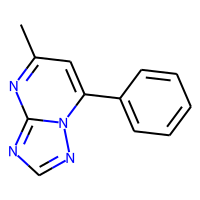
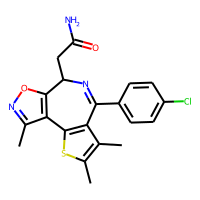
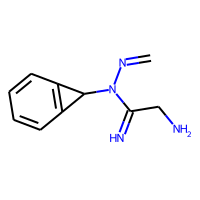
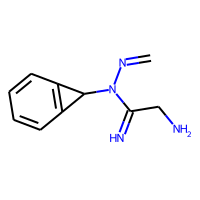
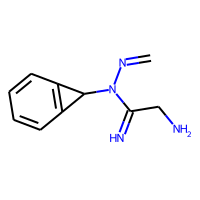
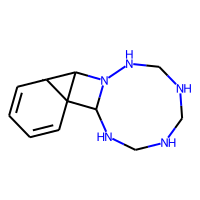
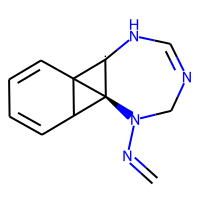
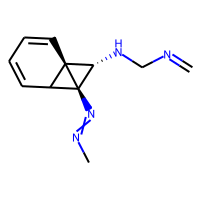
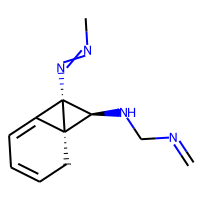
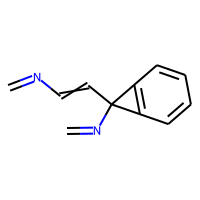
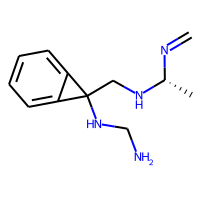
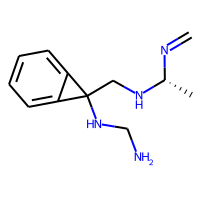
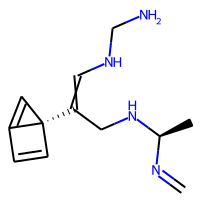
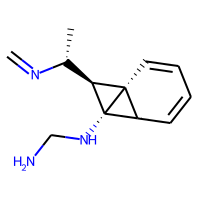
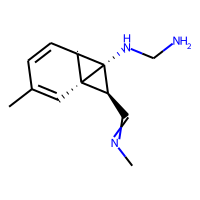
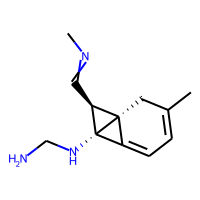
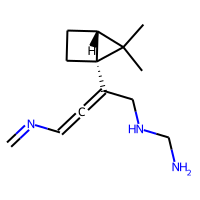
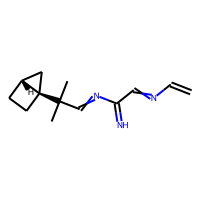
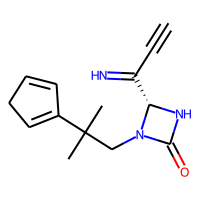
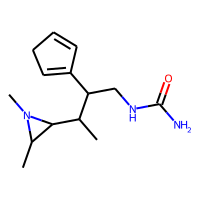
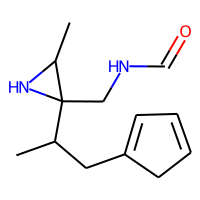
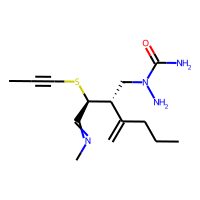
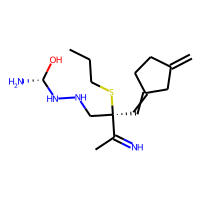
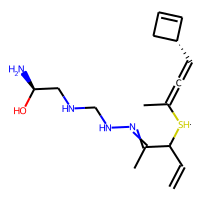
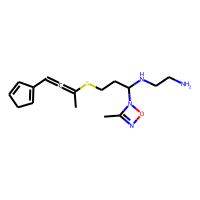
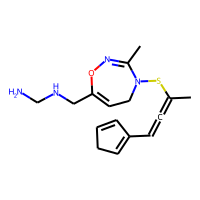
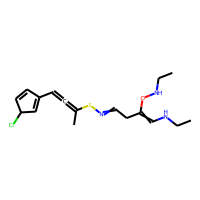
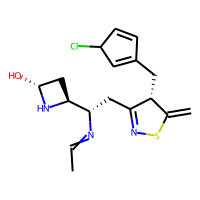
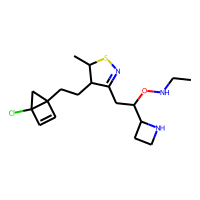
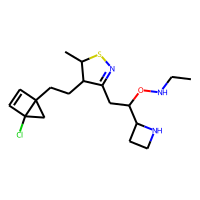

In [25]:
df.style.background_gradient(cmap=sns.cm.rocket, vmin=0, vmax=1)

<AxesSubplot:>

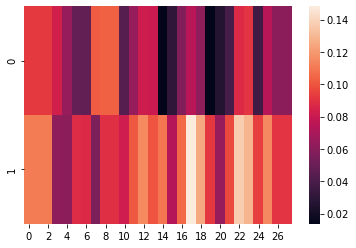

In [26]:
sns.heatmap(df.to_numpy().T)

## Second Interpolation

In [27]:
idx = 1 # Interpolation index (first pair, second pair, ...)
key = list(interpolations.keys())[idx]

In [28]:
key

'ligand-2/ligand-3'

In [29]:
tsim_start, tsim_end = tsimilarity(interpolations[key])

Text(0, 0.5, 'Tanimoto Similatiry')

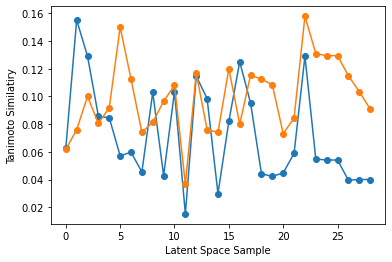

In [30]:
plt.plot(range(len(tsim_start)), tsim_start,"o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), tsim_end,"o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")

In [31]:
msim_start, msim_end = msimilarity(interpolations[key])

Text(0.5, 1.0, 'MACCS')

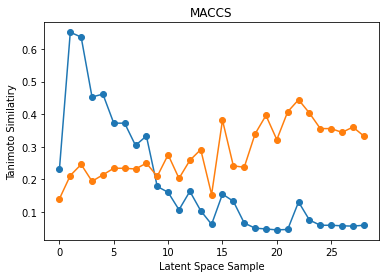

In [32]:
plt.plot(range(len(tsim_start)), msim_start,"o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), msim_end,"o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")
plt.title("MACCS")

In [33]:
df = pd.DataFrame().from_dict({"sim_start": tsim_start, "sim_end": tsim_end})
df.head()

,sim_start,sim_end
0,0.062500,0.061728
1,0.155172,0.075949
2,0.129032,0.100000
3,0.085714,0.080460
4,0.084507,0.091954


In [34]:
df.index = interpolations[key][1:-1]
df.columns = [interpolations[key][0], interpolations[key][-1]]

,,
,0.062500,0.061728
,0.155172,0.075949
,0.129032,0.100000
,0.085714,0.080460
,0.084507,0.091954
,0.057143,0.150000
,0.059701,0.112500
,0.045455,0.074074
,0.102941,0.081395
,0.042857,0.096386

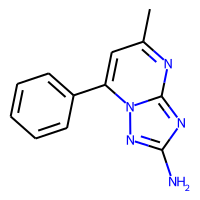
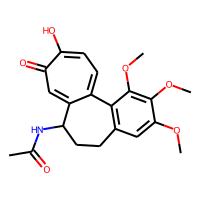
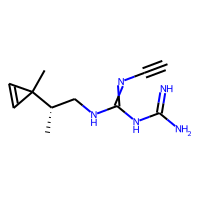
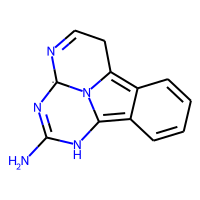
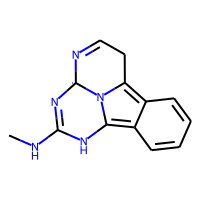
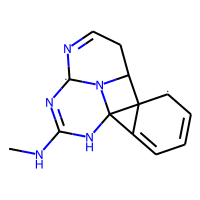
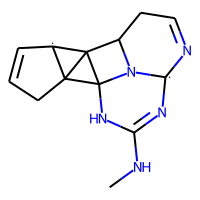
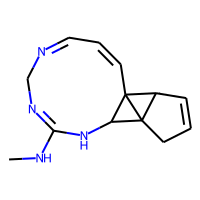
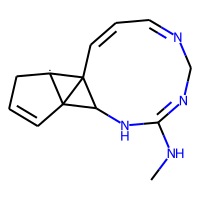
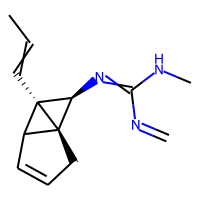
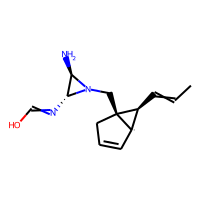
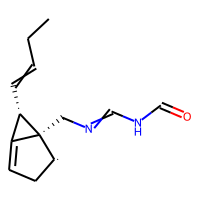
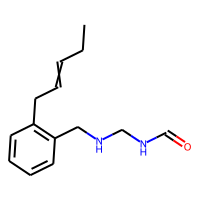
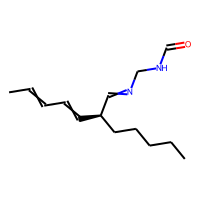
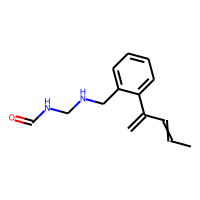
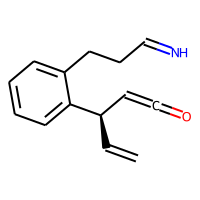
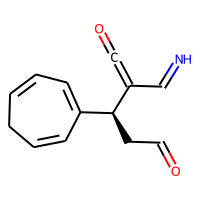
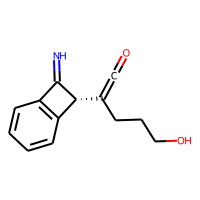
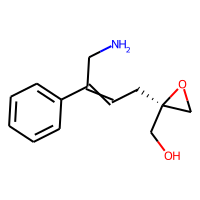
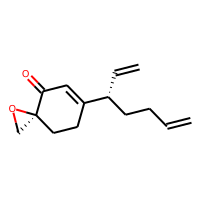
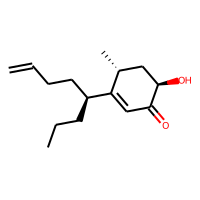
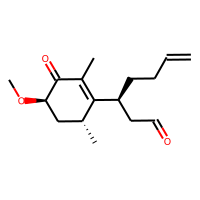
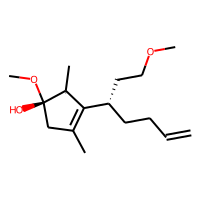
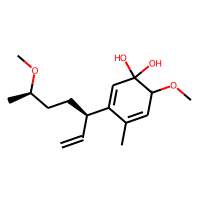
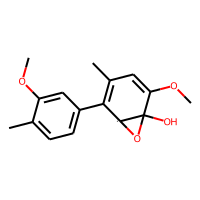
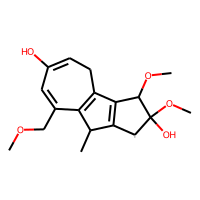
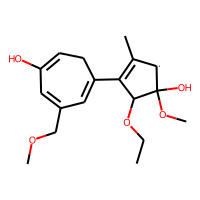
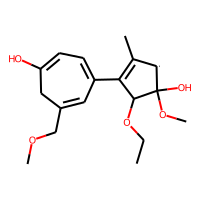
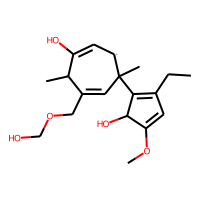
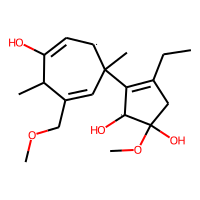
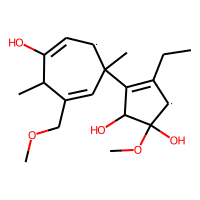

In [35]:
df.style.background_gradient(cmap=sns.cm.rocket, vmin=0, vmax=1)

<AxesSubplot:>

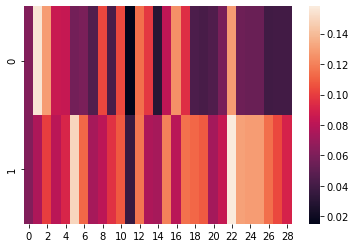

In [36]:
sns.heatmap(df.to_numpy().T)